In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'plot_major_isoform_gene_exp',
        root = '..',
        default_wildcards={'sample': 'WTC11'}
    )

In [2]:
from pathlib import Path 
import pyranges as pr
import pandas as pd
from lapa.result import LapaResult
import numpy as np

results = dict()

for i in snakemake.input['lapa_dir']:
    library_prep, platform, _ = Path(i).name.split('_')
    results[f'{library_prep} {platform}'] = LapaResult(i, replicated=False)

In [15]:
df_genes = pd.read_csv(snakemake.input['genes'])
df_genes['gene_id'] = df_genes['gene_id'].str.split('.').str.get(0)
df_genes = df_genes[df_genes['gene_type'] == 'protein_coding']

In [16]:
df_exp = pd.read_csv(snakemake.input['gene_exp'], sep='\t')
df_exp = df_exp[df_exp['TPM'] > 0]
df_exp['gene_id'] = df_exp['gene_id'].str.split('.').str.get(0)
df_exp = df_exp[df_exp['gene_id'].str.startswith('ENSG')]
df_exp = df_exp[df_exp['gene_id'].isin(set(df_genes['gene_id']))]

In [17]:
thresholds = {
    (1, 2): '1-2', 
    (2, 5): '2-5', 
    (5, 10): '5-10', 
    (10,50): '10-50', 
    (50, np.inf): '50+', 
}

genes_thresholds = dict()

for lower, upper in thresholds:
    gene_ids = df_exp[(df_exp['TPM'] > lower) & (df_exp['TPM'] <= upper)]['gene_id']    
    genes_thresholds[(lower, upper)] = set(gene_ids)

In [18]:
from collections import defaultdict

counts = defaultdict(dict)

for i in results:
    df = results[i].read_clusters()
    df['gene_id'] = df['gene_id'].str.split('.').str.get(0)
    df = df[df['gene_id'].str.startswith('ENSG')]
    
    df = df.sort_values('usage', ascending=False).drop_duplicates(subset='gene_id')
    df = df[df['signal'] != 'None@None']
    
    for (u, l), genes in genes_thresholds.items():
        counts[i][(u, l)] = df['gene_id'].isin(genes).sum()

/data/homezvol2/mcelik/Projects/lapa/lapa/utils/io.py:122: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, header=None, sep='\t')


In [19]:
df = list()

for name in counts:
    for tpm, c in counts[name].items():
        df.append({
            'data source': name.replace('quantseq', 'Quantseq3'),
            'TPM': thresholds[tpm],
            'number of genes': c,
            'percentage': 100 * c / len(genes_thresholds[tpm])
        })
        
df = pd.DataFrame(df)

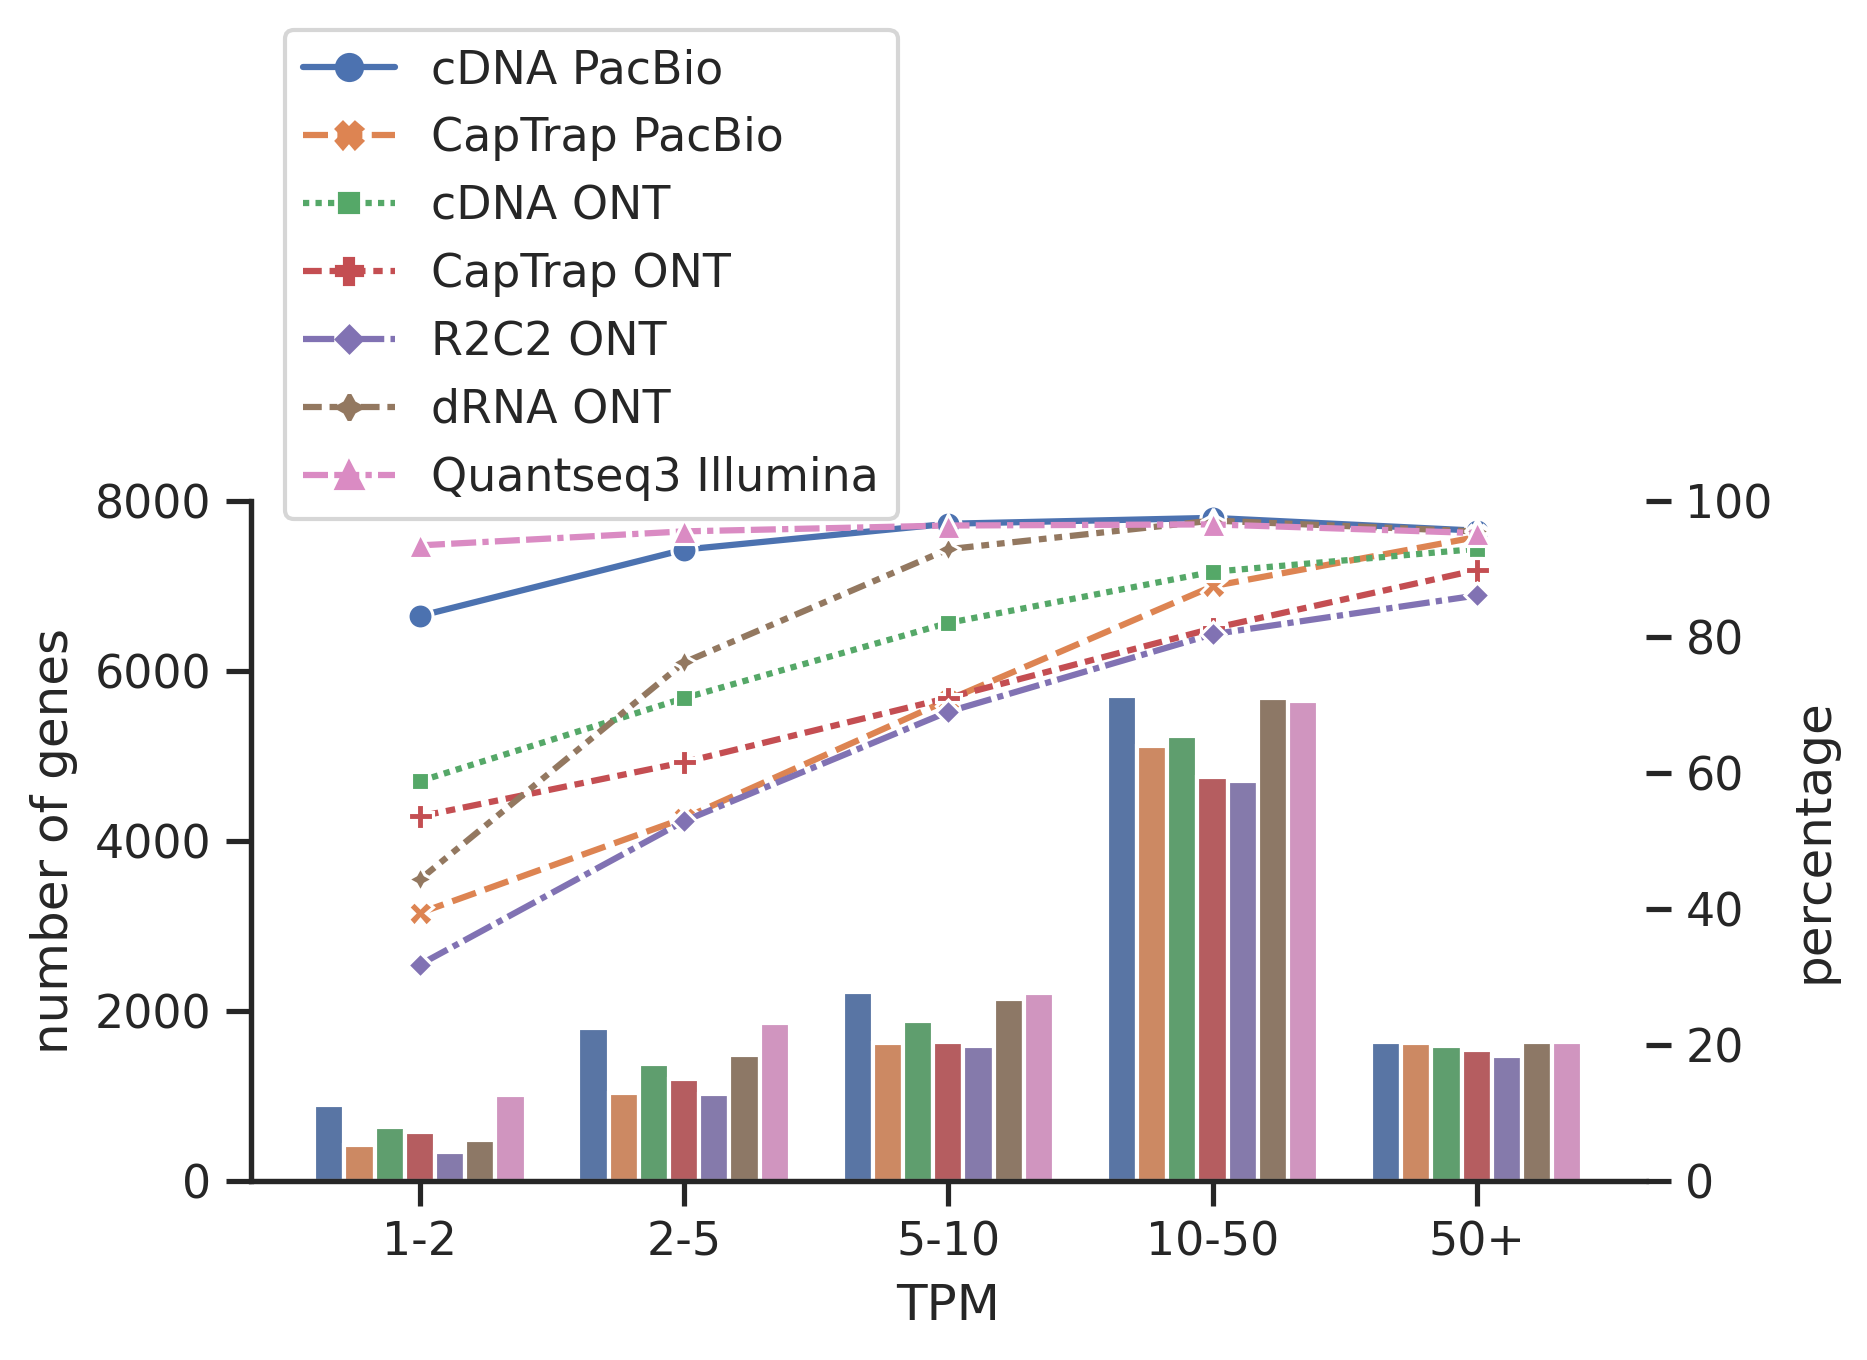

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.figure(figsize=(6, 3), dpi=300)

ax1 = sns.barplot(x="TPM", y="number of genes", hue='data source', data=df)
ax1.legend().set_visible(False)

plt.ylim((0, 8000))
ax2 = plt.twinx()
g = sns.lineplot(x="TPM", y="percentage", hue='data source', 
             style='data source', data=df, ax=ax2, markers=True)
ax2.legend(bbox_to_anchor=(0.48, 0.94))
plt.ylim((0, 100))
plt.savefig(snakemake.output['hist'], bbox_inches = "tight")

In [30]:
df = list()

for i in results:
    _df = results[i].read_clusters(filter_internal_priming=False)    
    _df = _df[_df['tpm'] > 5]

    with_signal = _df.assign(is_signal=lambda x: x['signal'] != 'None@None') \
        .groupby('fracA')[['is_signal']].sum()
    
    total = _df.groupby('fracA')[['signal']].count()
    
    df.append(pd.DataFrame({
        'frac': with_signal['is_signal'] / total['signal'],
        'data source': i
    }))
    
df = pd.concat(df)

/data/homezvol2/mcelik/Projects/lapa/lapa/utils/io.py:122: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, header=None, sep='\t')
/data/homezvol2/mcelik/Projects/lapa/lapa/result.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df['Chromosome'] + ':' \


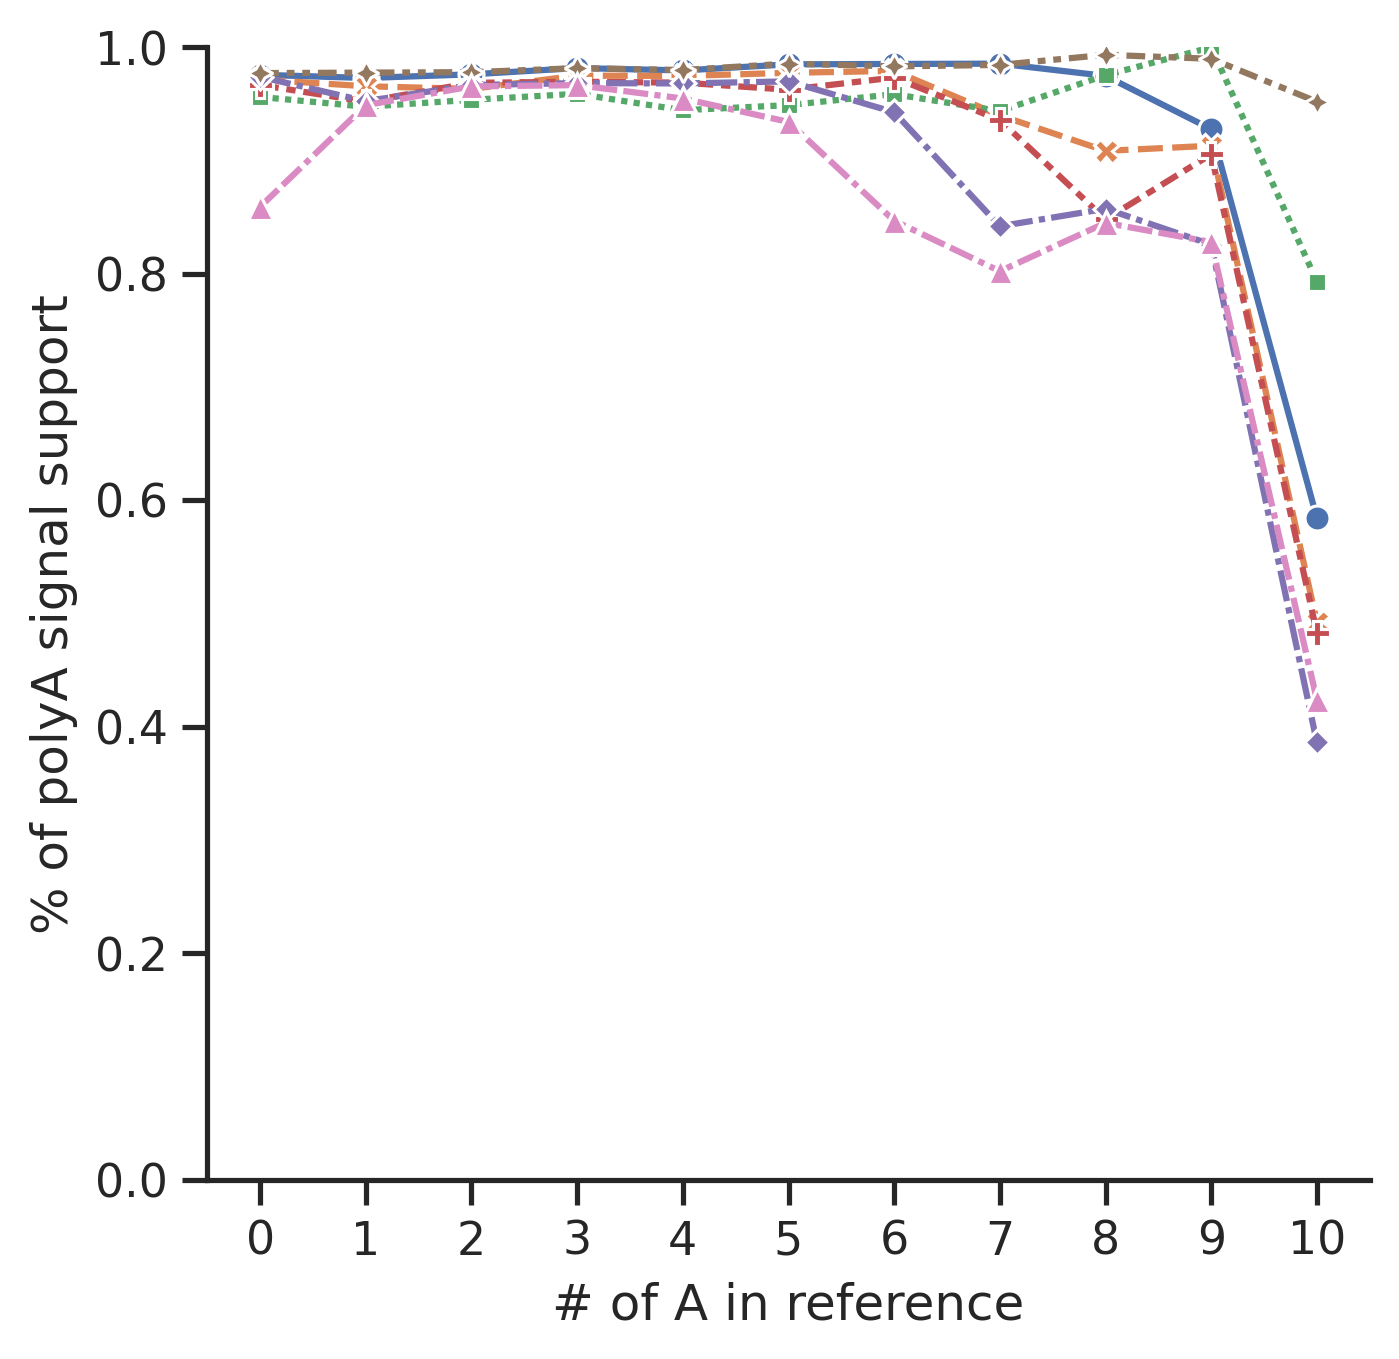

In [31]:
plt.figure(figsize=(5, 5), dpi=300)
ax = sns.lineplot(data=df.reset_index(), x="fracA", y="frac", hue='data source', 
                  style='data source', markers=True)
ax.legend().set_visible(False)

plt.xlabel('# of A in reference')
plt.ylabel('% of polyA signal support')
plt.ylim((0, 1))
_ = plt.xticks(range(0, 11))
plt.savefig(snakemake.output['fracA'], bbox_inches = "tight")